In [1]:
import numpy
import pandas

import json

from matplotlib import pyplot as plt

In [2]:
with open("configs/microns_placement_2.json", "r") as fid:
    cfg = json.load(fid)

plot_out = cfg["plotting"]["output_root"]
save_out = cfg["save"]["filename"]
save_id = cfg["save"]["id"]

cfg

{'connectome': {'cols_xyz': ['x_nm', 'y_nm', 'z_nm'],
  'loading': {'conntility': '/scratch/datasets/microns_reimann/microns_mm3_connectome.h5',
   'args': ['condensed']},
  'subnetwork': {'base_volume': [],
   'simplices': [{'column': 'cell_type',
     'function': 'isin',
     'args': [['23P', '4P', '6CT', '5P_IT', '5P_PT', '5P_NP', '6IT']]},
    {'column': 'x_nm', 'function': 'gt', 'args': [550000.0]},
    {'column': 'x_nm', 'function': 'lt', 'args': [1050000.0]},
    {'column': 'z_nm', 'function': 'gt', 'args': [750000.0]},
    {'column': 'z_nm', 'function': 'lt', 'args': [1050000.0]}],
   'neurons': {'name': 'Inhibitory',
    'filters': [{'column': 'cell_type',
      'function': 'isin',
      'args': [['BC', 'MC', 'NGC']]}]}}},
 'analysis': {'simplex_dimension': 6,
  'use_weight': 0,
  'min_degrees': {'In': 200, 'Out': 200},
  'normalize_mat': 0,
  'clustering': {'use': 'source',
   'cluster_param': 2.2,
   'merge_smaller_than': 0.05,
   'normalize_cluster_paths': 'pairs',
   'norm

In [3]:
from helpers import network, plotting

cfg["connectome"]["loading"]["conntility"] = "/home/reimann/Documents/data/microns/microns_mm3_connectome.h5"

M = network.load_network(cfg["connectome"]["loading"])
Msmpl = network.filter_network(M, cfg["connectome"]["subnetwork"]["simplices"])
name_nrn = cfg["connectome"]["subnetwork"]["neurons"]["name"]
Mnrn = network.filter_network(M, cfg["connectome"]["subnetwork"]["neurons"]["filters"])

In [4]:
# dx = numpy.linspace(-0.15E6, 0.15E6, 5)
# dy = numpy.linspace(-0.05E6, 0.05E6, 3)
# i = 0

# for _dx in dx:
#     for _dy in dy:
#         with open("helpers/config.json", "r") as fid:
#             _cfg = json.load(fid)
#         _lst_use = []
#         for entry in cfg["connectome"]["subnetwork"]["simplices"]:
#             entry = entry.copy()
#             if entry["column"] == "x_nm":
#                 entry["args"] = [entry["args"][0] + _dx]
#             elif entry["column"] == "z_nm":
#                 entry["args"] = [entry["args"][0] + _dy]
#             _lst_use.append(entry)
#         _cfg["connectome"]["subnetwork"]["simplices"] = _lst_use
#         _cfg["plotting"]["output_root"] = "plots/microns/{0}".format(i)
#         _cfg["save"]["id"] = i
#         with open("configs/microns_placement_{0}.json".format(i), "w") as fid:
#             json.dump(_cfg, fid, indent=2)
#         i += 1

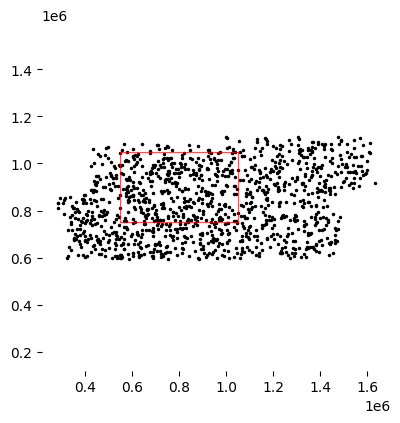

In [5]:
cols_xz = numpy.array(cfg["connectome"]["cols_xyz"])[[0, 2]]
n = int(len(M) / 50)
plt_xz = M.vertices[cols_xz].iloc[numpy.random.choice(len(M), n, replace=False)]

fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()

ax.plot(plt_xz.values[:, 0], plt_xz.values[:, 1], 'k.', ms=3)
plt.axis("equal")
ax.set_frame_on(False)

xlim = numpy.array(ax.get_xlim()); ylim = numpy.array(ax.get_ylim())
for entry in cfg["connectome"]["subnetwork"]["simplices"]:
    if entry["column"] == cols_xz[0]:
        if entry["function"] in ["gt", "geq"]:
            xlim[0] = entry["args"][0]
        elif entry["function"] in ["lt", "leq"]:
            xlim[1] = entry["args"][0]
    elif entry["column"] == cols_xz[1]:
        if entry["function"] in ["gt", "geq"]:
            ylim[0] = entry["args"][0]
        elif entry["function"] in ["lt", "leq"]:
            ylim[1] = entry["args"][0]

ax.plot(xlim, [ylim[0], ylim[0]], color="red", lw=0.5)
ax.plot(xlim, [ylim[1], ylim[1]], color="red", lw=0.5)
ax.plot([xlim[0], xlim[0]], ylim, color="red", lw=0.5)
ax.plot([xlim[1], xlim[1]], ylim, color="red", lw=0.5)

In [6]:
#### RANDOMIZATION. OPTIONAL
from helpers.randomization import create_dd_control_networks

if "randomization" in cfg["connectome"].keys():
    cols_coords = cfg["connectome"]["randomization"]["cols_coords"]
    model_name = cfg["connectome"]["randomization"]["model_name"] # Currently not used!
    Msmpl, Mnrn = create_dd_control_networks(M, Msmpl, Mnrn, cols_coords, model_name, cfg)

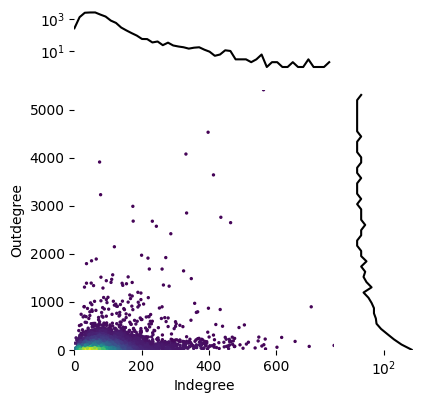

In [7]:
from helpers.plotting import indegree_outdegree_figure

indeg_smpl = numpy.array(Msmpl.matrix.sum(axis=0)).flatten()
outdeg_smpl = numpy.array(Msmpl.matrix.sum(axis=1)).flatten()
plotting.save_plot(indegree_outdegree_figure(indeg_smpl, outdeg_smpl, 51),
                   plot_out, "simplex_inout_degrees")

In [8]:
from helpers import analysis
from helpers.bootstrap import save_data

dimensions = [cfg["analysis"]["simplex_dimension"]]
#dimensions = [3, 4]

simplices, df_gids, df_idxs, ugids = analysis.get_simplex_dataframes(Msmpl, dimensions)
ugid = ugids[0]
df_gid = df_gids[0]
df_idx = df_idxs[0]
tgt_dim = dimensions[0]

save_data(simplices.apply(len), save_out, save_id, "simplex_counts")

 2023-11-12 14:32:41,038: COMPUTE list of simplices by dimension
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:35<00:00, 215.21s/it]
/home/reimann/venvs/bpsnap/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


/home/reimann/venvs/bpsnap/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/mnt/c/Users/reima/Documents/code/excitation_inhibition_topology_github/helpers/bootstrap.py:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  df.to_hdf(filename, key="{0}/{1}".format(dset, data_id))


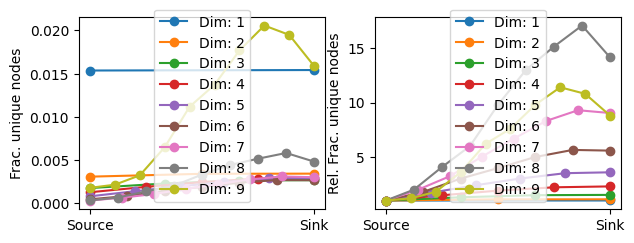

In [9]:
from helpers import plotting, analysis

divergences = analysis.get_divergences(simplices)
plotting.save_plot(plotting.plot_simplex_divergences(divergences),
                   plot_out, "per_degree_divergence")

save_data(divergences, save_out, save_id, "divergences")

In [10]:
m_nrn_smpl, m_smpl_nrn = analysis.exc_inh_sparce_matrices(M, ugid, Mnrn.gids)
s_n_paths, n_s_paths = analysis.get_simplex_neuron_path_df(m_nrn_smpl, m_smpl_nrn, df_idx, name_nrn)

KeyboardInterrupt: 

In [ ]:
classic_indeg = numpy.array(m_smpl_nrn.sum(axis=0)).flatten()
classic_outdeg = numpy.array(m_nrn_smpl.sum(axis=1)).flatten()

plotting.save_plot(indegree_outdegree_figure(classic_indeg, classic_outdeg, 31),
                   plot_out, "neuron_classic_degrees")

nrn_degrees = analysis.simplex_specific_inout_degrees(s_n_paths, n_s_paths, name_nrn)
plotting.save_plot(indegree_outdegree_figure(nrn_degrees["In"].values, nrn_degrees["Out"].values, 31),
                   plot_out, "neuron_simplex_degrees")

In [ ]:
numpy.corrcoef(nrn_degrees.values.transpose())

In [ ]:
from matplotlib import pyplot as plt

fig1 = plotting.plot_position_degrees(s_n_paths)
ax = plt.gcf().gca()
ax.set_title("Simplex -> {0}".format(name_nrn))

fig2 = plotting.plot_position_degrees(n_s_paths)
ax = plt.gcf().gca()
ax.set_title("{0} -> Simplex".format(name_nrn))

plotting.save_plot(fig1, plot_out, "per_position_outdegree")
plotting.save_plot(fig1, plot_out, "per_position_indegree")

In [ ]:
fig1 = plotting.plot_position_mean(s_n_paths)
ax = plt.gcf().gca()
ax.set_title("Simplex -> {0}".format(name_nrn))

fig2 = plotting.plot_position_mean(n_s_paths)
ax = plt.gcf().gca()
ax.set_title("{0} -> Simplex".format(name_nrn))

plotting.save_plot(fig1, plot_out, "per_position_out_syns_con")
plotting.save_plot(fig1, plot_out, "per_position_in_syns_con")

In [ ]:
is_smpl = numpy.isin(M.gids, Msmpl.gids)
is_nrn = numpy.isin(M.gids, Mnrn.gids)

smpl_outdeg = numpy.array(M.matrix.tocsc()[numpy.ix_(is_smpl, is_nrn)].sum(axis=1)).flatten()
smpl_indeg = numpy.array(M.matrix.tocsc()[numpy.ix_(is_nrn, is_smpl)].sum(axis=0)).flatten()

classic_in = pandas.DataFrame(smpl_indeg[simplices[1]], columns=[0, 1])
classic_out = pandas.DataFrame(smpl_outdeg[simplices[1]], columns=[0, 1])
smpl_in = n_s_paths.groupby(["Simplex", "Position"]).count().unstack("Position", fill_value=0)
smpl_out = s_n_paths.groupby(["Simplex", "Position"]).count().unstack("Position", fill_value=0)

all_classic = pandas.concat([classic_in, classic_out], axis=1, keys=["In", "Out"])
all_smpl = pandas.concat([smpl_in, smpl_out], axis=1, keys=["In", "Out"])

plotting.save_plot(plotting.summary_position_degrees(all_classic, all_smpl),
                   plot_out, "per_position_degrees_summary")
save_data(all_classic, save_out, save_id, "classic_degree_per_pos")
save_data(all_smpl, save_out, save_id, "simplex_degree_per_pos")

In [ ]:
is_high_deg = numpy.all(nrn_degrees >= pandas.Series(cfg["analysis"]["min_degrees"]), axis=1)
rnd_smpl = numpy.random.choice(is_high_deg.index[is_high_deg])

I = analysis.get_disynaptic_path_sum(s_n_paths.reorder_levels([2, 1, 0])[rnd_smpl],
                                     n_s_paths.reorder_levels([2, 1, 0])[rnd_smpl],
                                     tgt_dim, use_weight=bool(cfg["analysis"]["use_weight"]))
plotting.save_plot(plotting.plot_disynaptic_path_sum(I),
                   plot_out, "double_position_degrees_example")

In [ ]:
I = analysis.sum_disynaptic_path_sum(s_n_paths, n_s_paths, tgt_dim, name_nrn,
                                     min_degree=cfg["analysis"]["min_degrees"],
                                     use_weight=bool(cfg["analysis"]["use_weight"]))
plotting.save_plot(plotting.plot_disynaptic_path_sum(I),
                   plot_out, "double_position_degrees_mean")

save_data(pandas.DataFrame(I), save_out, save_id, "double_position_degrees")

In [ ]:
tgt_shape = (len(df_gid), len(Mnrn))
disyn_nrn_mat = analysis.get_disynaptic_con_mat(s_n_paths, n_s_paths, name_nrn, tgt_shape,
                                                use_weight=bool(cfg["analysis"]["use_weight"]),
                                                normalize=bool(cfg["analysis"].get("normalize_mat", 0)))
disyn_ctrl_mat = analysis.get_disynaptic_con_mat(s_n_paths, n_s_paths, name_nrn, tgt_shape,
                                                 use_weight=bool(cfg["analysis"]["use_weight"]),
                                                 normalize=bool(cfg["analysis"].get("normalize_mat", 0)),
                                                 shuffle_cols=[name_nrn])

In [ ]:
fig1 = plt.figure()
ax = fig1.gca()
plt.colorbar(ax.imshow((disyn_nrn_mat), interpolation="nearest"))

fig2 = plt.figure()
ax = fig2.gca()
plt.colorbar(ax.imshow((disyn_ctrl_mat), interpolation="nearest"))

plotting.save_plot(fig1, plot_out, "disyn_inhibition_data")
plotting.save_plot(fig2, plot_out, "disyn_inhibition_shuffled")

In [ ]:
hists = analysis.histogram_data_and_ctrl(disyn_nrn_mat, disyn_ctrl_mat, 101)
fig = plotting.compare_disyn_inhibition(hists)
plt.gca().set_frame_on(False)
plotting.save_plot(fig, plot_out, "disyn_inhibition_distributions")
save_data(hists, save_out, save_id, "disyn_inhibition_histograms")

In [ ]:
disyn_mat_directedness = pandas.Series({
    "Control": numpy.var(disyn_ctrl_mat - disyn_ctrl_mat.transpose()) / numpy.var(disyn_ctrl_mat),
    "Data": numpy.var(disyn_nrn_mat - disyn_nrn_mat.transpose()) / numpy.var(disyn_nrn_mat)
})
display(disyn_mat_directedness)
save_data(disyn_mat_directedness, save_out, save_id, "disyn_inhibition_directedness")

In [ ]:
_sz = tgt_dim + 1
_idx_low = numpy.arange(int(numpy.floor(_sz / 2)))
_idx_high = numpy.arange(int(numpy.ceil(_sz / 2)), _sz)

ol_src = analysis.simplex_overlap_in_positions(df_idx, _idx_low, ugid)
ol_tgt = analysis.simplex_overlap_in_positions(df_idx, _idx_high, ugid)
ol_all = analysis.simplex_overlap_in_positions(df_idx, numpy.arange(tgt_dim + 1), ugid)

In [ ]:
fig1 = plt.figure()
ax = fig1.gca()
plt.colorbar(ax.imshow(ol_src, interpolation="nearest"))

fig2 = plt.figure()
ax = fig2.gca()
plt.colorbar(ax.imshow(ol_tgt, interpolation="nearest"))

plotting.save_plot(fig1, plot_out, "overlap_source")
plotting.save_plot(fig2, plot_out, "overlap_target")

In [ ]:
def offdiagonal(mat):
    return mat[numpy.eye(mat.shape[0]) == 0]

ol_src_f = offdiagonal(ol_src)
ol_tgt_f = offdiagonal(ol_tgt)
hists = analysis.histogram_data_and_ctrl(offdiagonal(ol_tgt), offdiagonal(ol_src), [0, 1, 2, 3, 4])
bins = hists.index.values

fig = plt.figure(figsize=(3, 1.5))
ax = fig.gca()

ax.plot(hists["Control"][1:], color="red", label="Source side")
ax.plot(hists["Data"][1:], color="blue", label="Target side")
plt.legend()
ax.set_frame_on(False)
ax.set_xlim([bins[0] - 0.2, bins[-1] + 0.2])
ax.set_xticks(bins)
ylim = ax.get_ylim(); ax.set_ylim(ylim)
yy = 0.9 * ylim[1] + 0.1 * ylim[0]

ax.text(0, 0.8*yy, "^{0}".format(hists["Control"][0]), color="red")
ax.text(0, yy, "^{0}".format(hists["Data"][0]), color="blue")
ax.set_xlabel("Overlapping neuron count")
ax.set_ylabel("Simplex pair count")

plotting.save_plot(fig, plot_out, "overlap_counts_source_target")
save_data(hists, save_out, save_id, "source_target_overlap_amounts")

In [ ]:
ol_disyn_mat, ol_disyn_cc, column_names = analysis.overlaps_vs_disyn(ol_src, ol_tgt, disyn_nrn_mat)
fig1 = plotting.plot_overlaps_vs_disyn(ol_disyn_mat)
fig2 = plotting.plot_overlap_vs_disyn_corr(ol_disyn_cc, column_names)

plotting.save_plot(fig1, plot_out, "overlaps_vs_disyn_inhibition")
plotting.save_plot(fig2, plot_out, "overlaps_disyn_inhibition_correlations")

save_data(ol_disyn_mat, save_out, save_id, "overlap_vs_disyn_mat")
save_data(pandas.DataFrame(ol_disyn_cc, index=column_names, columns=column_names),
          save_out, save_id, "overlap_vs_disyn_cc")

In [ ]:
grp_df_full = analysis.simplex_clustering(ol_src, ol_tgt, cfg["analysis"]["clustering"]["cluster_param"])

if "merge_smaller_than" in cfg["analysis"]["clustering"]:
    grp_df = analysis.merge_small_clusters(grp_df_full, cfg["analysis"]["clustering"]["merge_smaller_than"])
else:
    grp_df = grp_df_full

lbls_src = grp_df["src_grp"]
lbls_tgt = grp_df["tgt_grp"]

idx = numpy.argsort(lbls_src)

fig = plt.figure()
fig.gca().imshow(ol_src[numpy.ix_(idx, idx)])
plotting.save_plot(fig, plot_out, "overlap_src_clst")

fig = plt.figure()
fig.gca().imshow(disyn_nrn_mat[numpy.ix_(idx, idx)])
plotting.save_plot(fig, plot_out, "overlap_tgt_clst")

save_data(grp_df.apply(lambda _x: _x.value_counts(), axis=0),
          save_out, save_id, "src_tgt_group_sizes")

In [ ]:
clst_mat_smplx = analysis.simplex_cluster_connectivity(df_idx, grp_df, ugid, cfg["analysis"]["clustering"]["normalize_cluster_paths"])

co = cfg["analysis"]["clustering"]["cutoff"]

if co["strategy"] == "percentile":
    cutoff = numpy.percentile(disyn_nrn_mat.flatten(), co["value"])
elif co["strategy"] == "percentile_control":
    cutoff = numpy.percentile(disyn_ctrl_mat.flatten(), co["value"])
elif co["strategy"] == "none":
    cutoff = None
elif co["strategy"] == "value":
    cutoff = co["value"]

clst_mat_disyn = analysis.simplex_cluster_disyn(disyn_nrn_mat, grp_df, cfg["analysis"]["clustering"]["normalize_cluster_disyn"], cutoff=cutoff)

In [ ]:
fig = plt.figure()
plt.colorbar(fig.gca().imshow(clst_mat_smplx, aspect="auto", interpolation="nearest"))

plotting.save_plot(fig, plot_out, "clustered_connectivity_smplx")

In [ ]:
fig = plt.figure()
plt.colorbar(fig.gca().imshow(clst_mat_disyn, aspect="auto", interpolation="nearest"))

plotting.save_plot(fig, plot_out, "clustered_connectivity_nrn")

In [ ]:
n, m = clst_mat_smplx.shape
Mm = numpy.vstack([
    numpy.hstack([numpy.zeros((n, n)), clst_mat_smplx]),
    numpy.zeros((m, n + m))])
Mn = numpy.vstack([
    numpy.hstack([numpy.zeros((n, n)), clst_mat_disyn]),
    numpy.zeros((m, n + m))])
import networkx

x = numpy.hstack([numpy.linspace(0, 1, n), numpy.linspace(0, 1, m)])
y = numpy.hstack([numpy.zeros(n), numpy.ones(m)])

plt.figure(figsize=(8, 8))

grph = networkx.DiGraph(Mn)
weights = []
for e in grph.edges:
    weights.append(Mn[e[0], e[1]])

weights = numpy.array(weights) / 1
networkx.draw_networkx(grph, numpy.vstack([x, y]).transpose(),
                      width=weights, with_labels=False, nodelist=[], edge_color="red")

grph = networkx.DiGraph(Mm)
weights = []
for e in grph.edges:
    weights.append(Mm[e[0], e[1]])

weights = numpy.array(weights) / 2
networkx.draw_networkx(grph, numpy.vstack([x + 0.005, y]).transpose(),
                      width=weights, with_labels=False, edge_color="blue")


In [ ]:
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()
ax.plot(clst_mat_smplx.flatten(), clst_mat_disyn.flatten(), 'k.')
ax.set_frame_on(False)
ax.set_xlabel("Excitation")
ax.set_ylabel("Inhibition")

plotting.save_plot(fig, plot_out, "clustered_simplex_vs_neuron_strength")

In [ ]:
lst_src_idx = grp_df["src_grp"].drop_duplicates().sort_values().values[:-1]
lst_src_idx = lst_src_idx[:10]

for i in lst_src_idx:
    smplx_tgt_ids = grp_df.reset_index().set_index("src_grp")["index"][i]

    figs = plotting.plot_simplex_group_as_network(smplx_tgt_ids, M, Msmpl, Mnrn, simplices[tgt_dim],
                                                  s_n_paths, n_s_paths, name_nrn, tgt_dim,
                                                  cfg["plotting"]["networks"])
    plotting.save_plot(figs, plot_out, "smplx_network_{0}_example".format(i))

Finding the I neurons most participating in these motifs

In [ ]:
# N_S = n_s_paths.reset_index().groupby(["Inhibitory", "Position"])[0].count().unstack("Position", fill_value=0)
# S_N = s_n_paths.reset_index().groupby(["Inhibitory", "Position"])[0].count().unstack("Position", fill_value=0)

In [ ]:
# N_Ssum = N_S.sum(axis=1)
# S_Nsum = S_N.sum(axis=1)

# N_Sdiff = N_S[6] - N_S[0]
# S_Ndiff = S_N[0] - S_N[6]

In [ ]:
# cand = (N_Ssum > 400) & (S_Nsum > 400) & (N_Sdiff > 200) & (S_Ndiff > 200)
# cand.index[cand].values

In [ ]:
# Mnrn.vertices["cell_type"].value_counts()

In [ ]:
# Mnrn.vertices.iloc[cand.index[cand].values]["cell_type"].value_counts()

In [ ]:
# Mnrn.vertices.iloc[cand.index[cand].values]